## Import Modeules

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

## Load the files

In [2]:
BASE_DIR ='/kaggle/input/anime-faces/data/'

In [3]:
# load complete image path to the list
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [4]:
image_paths[:5]

['/kaggle/input/anime-faces/data/21130.png',
 '/kaggle/input/anime-faces/data/9273.png',
 '/kaggle/input/anime-faces/data/18966.png',
 '/kaggle/input/anime-faces/data/14127.png',
 '/kaggle/input/anime-faces/data/18054.png']

In [5]:
# remove unnessesary files
image_paths.remove('/kaggle/input/anime-faces/data/data')

In [6]:
len(image_paths)

21551

## Visualize the image dataset

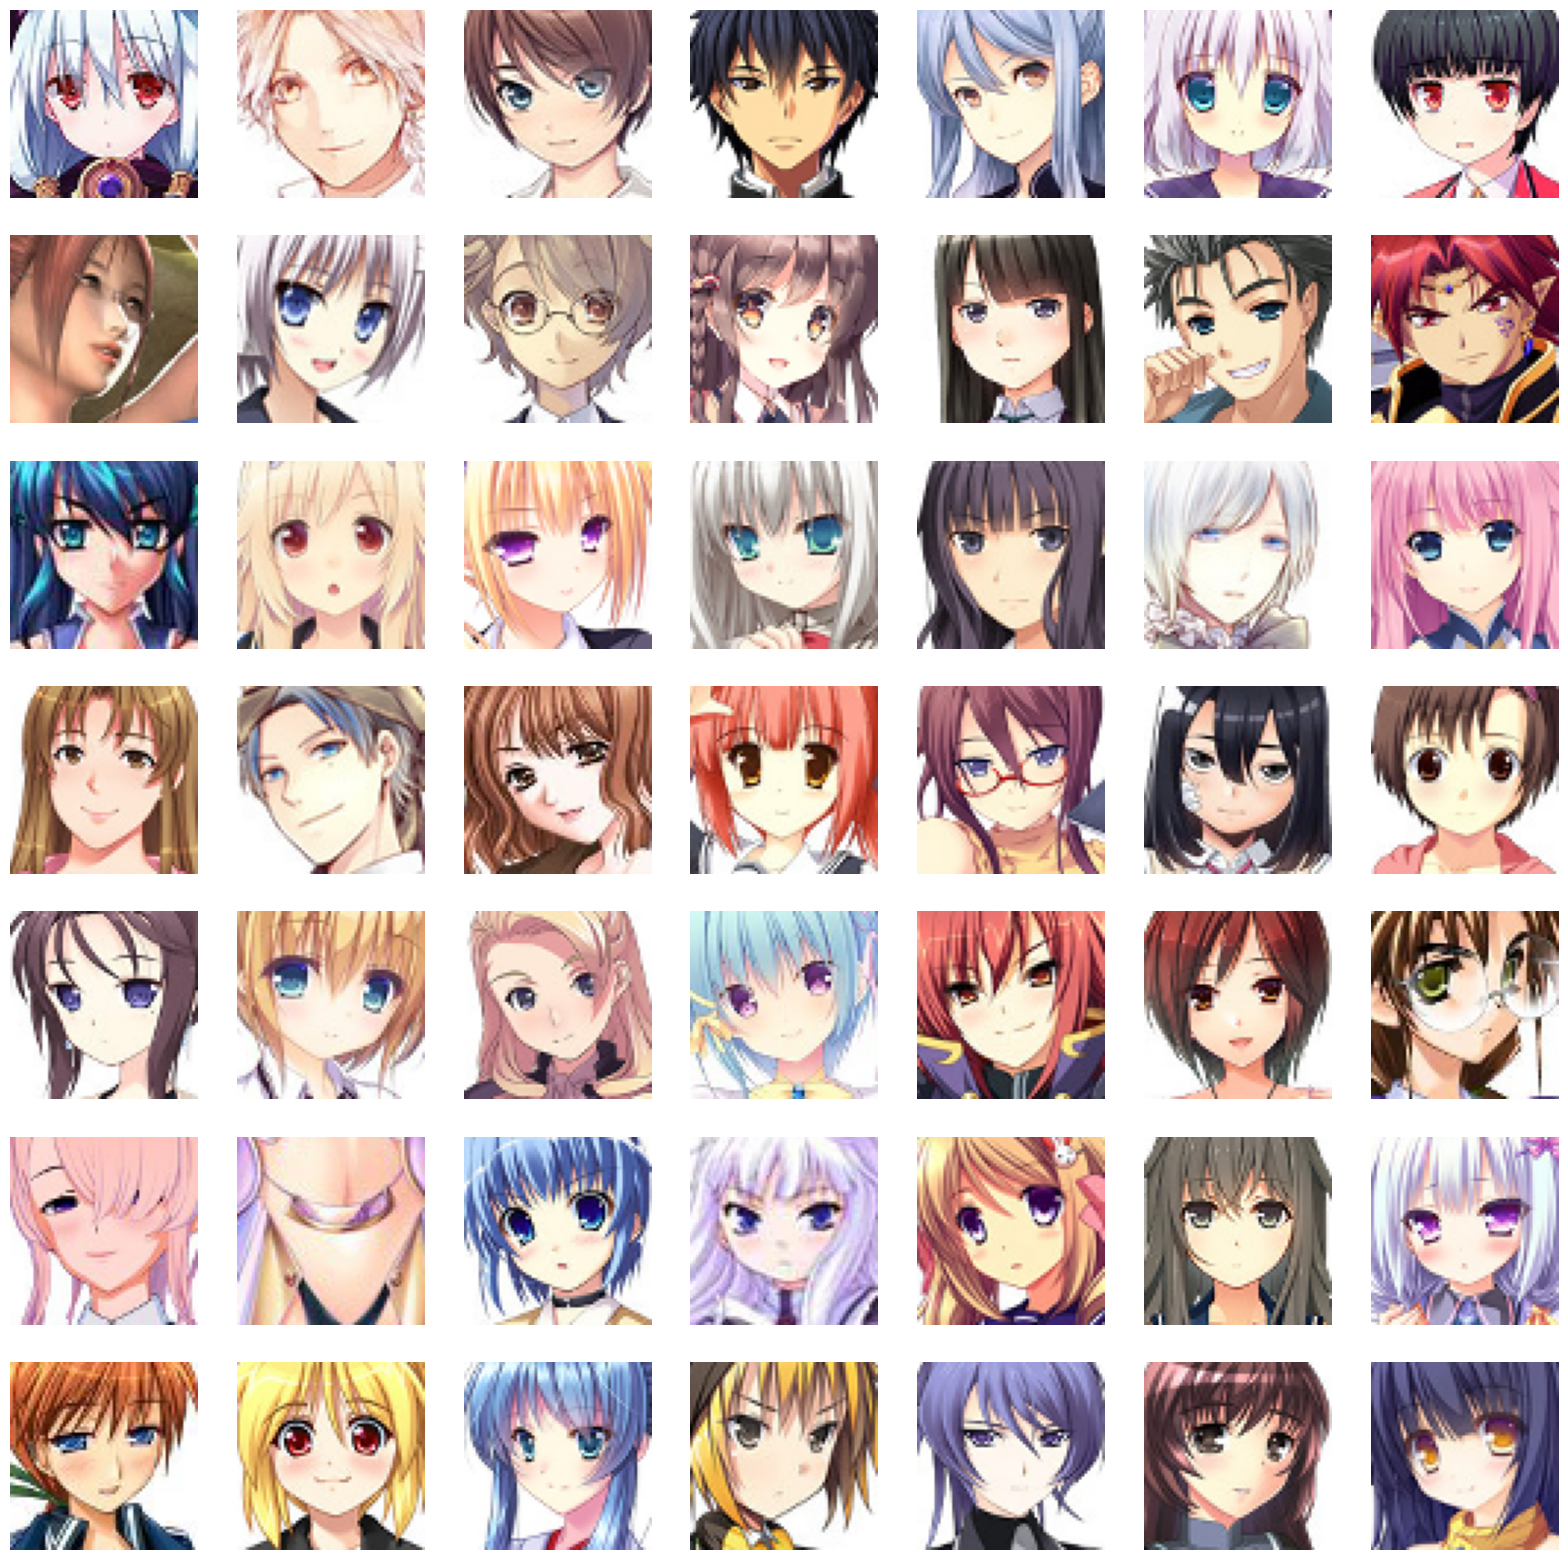

In [26]:
# to display grid of images(7x7)
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    #load the image
    img = load_img(image_path)
    #convert to numpy array
    img = np.array(img)
    #show the image
    plt.imshow(img)
    plt.axis('off')
    #increment the index for next image
    index += 1

## Preprocess the image

In [8]:
#load the image and convert to numpy array
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
train_images = np.array(train_images)

  0%|          | 0/21551 [00:00<?, ?it/s]

In [9]:
train_images[0].shape

(64, 64, 3)

In [10]:
#reshape the array
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')

In [11]:
#normalise the images
train_images = (train_images - 127.5) / 127.5

In [12]:
train_images[0]

array([[[-0.7254902 , -0.90588236, -0.7176471 ],
        [-0.70980394, -0.88235295, -0.6862745 ],
        [-0.7019608 , -1.        , -0.7176471 ],
        ...,
        [-0.09019608,  0.01176471,  0.3882353 ],
        [-0.19215687,  0.05882353,  0.4509804 ],
        [-0.34117648, -0.13725491,  0.29411766]],

       [[-0.7254902 , -0.90588236, -0.7176471 ],
        [-0.73333335, -0.8666667 , -0.7019608 ],
        [-0.52156866, -0.8666667 , -0.5686275 ],
        ...,
        [-0.29411766,  0.01176471,  0.3019608 ],
        [-0.08235294,  0.15294118,  0.5294118 ],
        [-0.23921569,  0.09019608,  0.45882353]],

       [[-0.7019608 , -0.8901961 , -0.7019608 ],
        [-0.7176471 , -0.8745098 , -0.69411767],
        [-0.5686275 , -0.8509804 , -0.58431375],
        ...,
        [-0.22352941,  0.1764706 ,  0.48235294],
        [-0.13725491,  0.1764706 ,  0.4745098 ],
        [-0.06666667,  0.24705882,  0.5058824 ]],

       ...,

       [[-0.30980393, -0.6862745 , -0.29411766],
        [-0

## Create Generator and Discriminator

In [13]:
#latent dimesnion for random noise (variety of images differs)
LATENT_DIM = 100
#weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
#no of channels of the image
CHANNELS = 3 #for gray scale, keep it as 1


# GENERATOR MODEL

this will create new images similar to training data from random noise

In [14]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

#upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,065,603 (23.14 MB)

 Trainable params: 6,065,603 (23.14 MB)

 Non-trainable params: 0 (0.00 B)

## DISCRIMINATOR MODEL

this will classify the image from the generator to check whether it is real or fake

In [15]:
model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

#create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,081 (1.55 MB)

 Trainable params: 405,441 (1.55 MB)

 Non-trainable params: 640 (2.50 KB)

# Create DCGAN

In [16]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
     
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        #get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        #train the discriminator with real(1) and fake(2) images
        with tf.GradientTape() as tape:
            #compute lose on real images
            pred_real = self.discriminator(real_images, training=True)
            #generate real image labels
            real_labels = tf.ones((batch_size, 1))
            #label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            #compute lose on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            #generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            #total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        #compute dsicriminator gradients
        gradients = tape.gradient(d_loss,self.discriminator.trainable_variables)
        #update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        #train the generator model
        labels = tf.ones((batch_size, 1))
        #generator wants discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            #generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            #classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            #compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        #compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        #update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        #update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [27]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        #create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])
        
    def on_epoch_end(self, epoch, logs=None):
        #generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalise the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        #plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [29]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [30]:
D_LR = 0.0001
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())


Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.8130 - g_loss: 0.9159

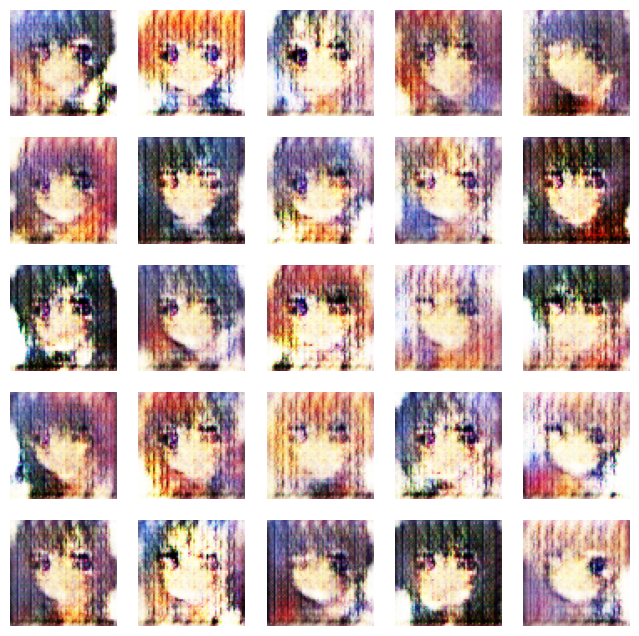

674/674 ━━━━━━━━━━━━━━━━━━━━ 1429s 2s/step - d_loss: 0.8130 - g_loss: 0.9159
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - d_loss: 0.7708 - g_loss: 0.7825

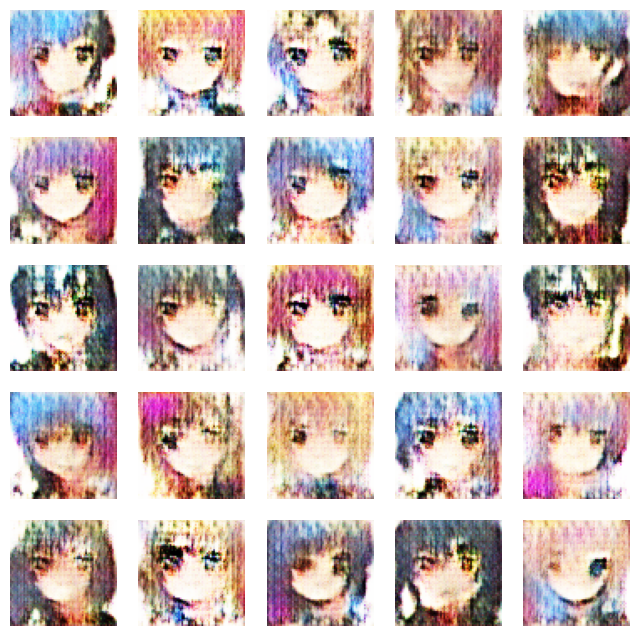

674/674 ━━━━━━━━━━━━━━━━━━━━ 1456s 2s/step - d_loss: 0.7708 - g_loss: 0.7824
Epoch 3/50
322/674 ━━━━━━━━━━━━━━━━━━━━ 12:19 2s/step - d_loss: 0.7507 - g_loss: 0.7289

In [ ]:
N_EPOCHS = 50
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])